In [4]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import string
import re
import nltk
import wordcloud
import langdetect
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from nltk.sentiment import SentimentIntensityAnalyzer


stop_words  = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Overview of the dataset

In [30]:
data = pd.read_csv("/kaggle/input/netflixmovie-reviews/new_dat.csv")
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (25000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  25000 non-null  int64 
 1   Text        25000 non-null  object
 2   Target      25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB
None


,Unnamed: 0,Text,Target
0,0,b'Bromwell High is a cartoon comedy. It ran at...,1
1,1,b'Homelessness (or Houselessness as George Car...,1
2,2,b'Brilliant over-acting by Lesley Ann Warren. ...,1
3,3,b'This is easily the most underrated film inn ...,1
4,4,b'This is not the typical Mel Brooks film. It ...,1


### Data Cleaning
1. Dropping the Unnamed column
2. checking for missing values

In [31]:
data.drop(columns=["Unnamed: 0"], axis=1,inplace=True)
data.head()

,Text,Target
0,b'Bromwell High is a cartoon comedy. It ran at...,1
1,b'Homelessness (or Houselessness as George Car...,1
2,b'Brilliant over-acting by Lesley Ann Warren. ...,1
3,b'This is easily the most underrated film inn ...,1
4,b'This is not the typical Mel Brooks film. It ...,1


In [10]:
data.isna().sum()

Text      0
Target    0
dtype: int64

#### Language Detection
To understand which language our data is in.
From the plot below, we see that all our Texts are in one language, English.

In [12]:
data["language"] = data["Text"].apply(lambda x: langdetect.detect(x) if x.strip() !=""else"")
data.head()

,Text,Target,language
0,b'Bromwell High is a cartoon comedy. It ran at...,1,en
1,b'Homelessness (or Houselessness as George Car...,1,en
2,b'Brilliant over-acting by Lesley Ann Warren. ...,1,en
3,b'This is easily the most underrated film inn ...,1,en
4,b'This is not the typical Mel Brooks film. It ...,1,en


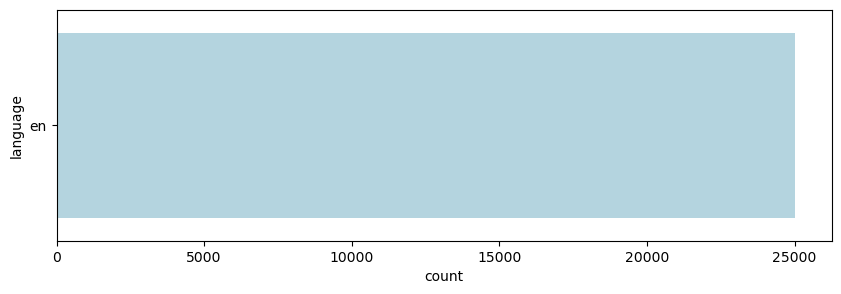

In [18]:
plt.figure(figsize=(10,3))
sns.countplot(y=data["language"], color="lightblue",order=data["language"].value_counts().index);
         

#### Exploring the target variable
We can see that both classes 0 and 1 have equal values, hence our data is well balanced.

In [19]:
data["Target"].value_counts()

1    12500
0    12500
Name: Target, dtype: int64

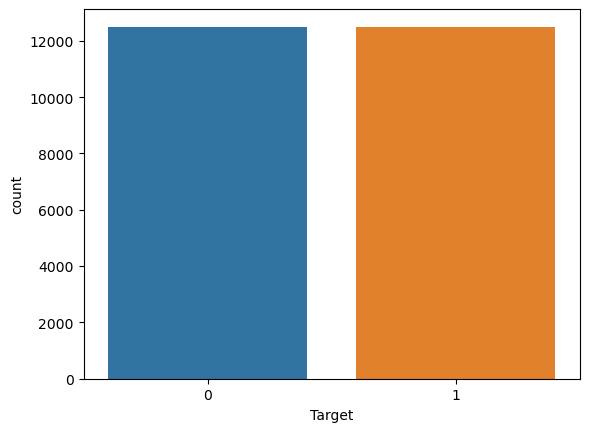

In [20]:
sns.countplot(x=data["Target"]);

### Text Preprocessing
1. **Lower case conversion** - converting all letters to lower case so as to avoid redundancy in interpretation of both lower and upper case letters differently.

In [33]:
def convert_lowercase(Text):
    Text = Text.lower()
    return Text

data["Text"] = data["Text"].apply(convert_lowercase)
data.head()

,Text,Target
0,b'bromwell high is a cartoon comedy. it ran at...,1
1,b'homelessness (or houselessness as george car...,1
2,b'brilliant over-acting by lesley ann warren. ...,1
3,b'this is easily the most underrated film inn ...,1
4,b'this is not the typical mel brooks film. it ...,1


2. **Removing special characters**/ punctuations from every headline

In [22]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))

data["Text"] = data["Text"].apply(remove_punc)
data.head()                               

,Text,Target
0,bbromwell high is a cartoon comedy it ran at t...,1
1,bhomelessness or houselessness as george carli...,1
2,bbrilliant overacting by lesley ann warren bes...,1
3,bthis is easily the most underrated film inn t...,1
4,bthis is not the typical mel brooks film it wa...,1


3. Removing the first character **b** from evert Text. 

In [38]:
data["Text"] = data["Text"].str[1:]
data.head()

,Text,Target
0,bromwell high is a cartoon comedy it ran at th...,1
1,homelessness or houselessness as george carlin...,1
2,brilliant overacting by lesley ann warren best...,1
3,this is easily the most underrated film inn th...,1
4,this is not the typical mel brooks film it was...,1


4. **Tokenization** - splitting up each of the headline into smaller units (words).
5. **Removing stopwords**
6. **Lemmatization** - reducing a word to its root or core meaning that makes sense on its own

In [40]:
def customtokenize(str):
    tokens = word_tokenize(str)
    non_stopwords = list(filter(lambda token: token not in stop_words,tokens))
    lemmatized = [lemmatizer.lemmatize(word) for word in non_stopwords]
    return lemmatized

data["Text"] = data["Text"].apply(customtokenize)
data["Text"] = data["Text"].apply(lambda l: " ".join(l))
data.head()

,Text,Target
0,bromwell high cartoon comedy ran time program ...,1
1,homelessness houselessness george carlin state...,1
2,brilliant overacting lesley ann warren best dr...,1
3,easily underrated film inn brook cannon sure f...,1
4,typical mel brook film much le slapstick movie...,1


Visualizing the **most common** used words in the Text

In [63]:
def plot_top_non_stopwords(text):
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    
    counter =Counter(corpus)
    most = counter.most_common()
    x, y=[], []
    for word,count in most[:10]:
        if (word not in stop_words):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,5))
    sns.barplot(x=y,y=x,orient="h")

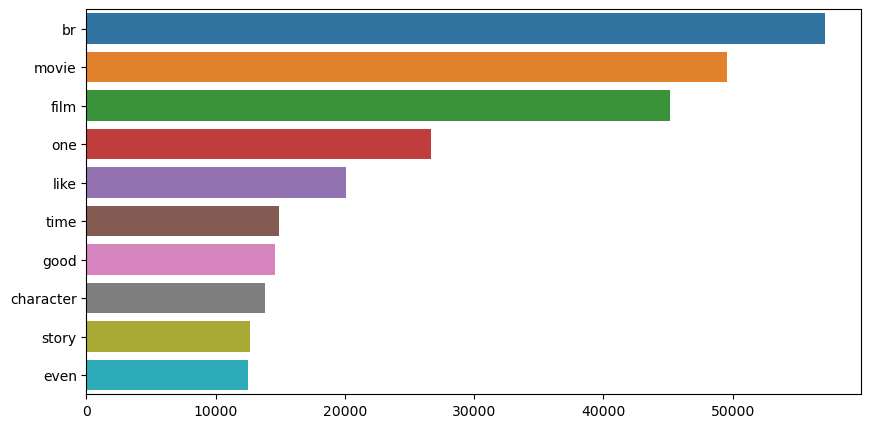

In [64]:
plot_top_non_stopwords(data["Text"])

Plotting **WordCloud** to visuzalize the most common used words for both **0:Positive review**  and **1: negative review** classes.

In [84]:
def plot_word_cloud(data,number):
    text = "".join(data["Text"])
    wc= WordCloud(background_color = "white",max_font_size=50, max_words=100)
    wc.generate(text)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"WordCloud for {number}")
    plt.axis("off")
    print()

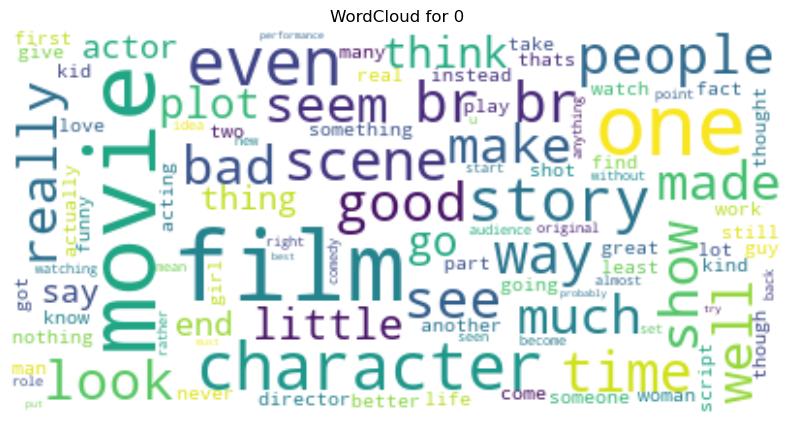

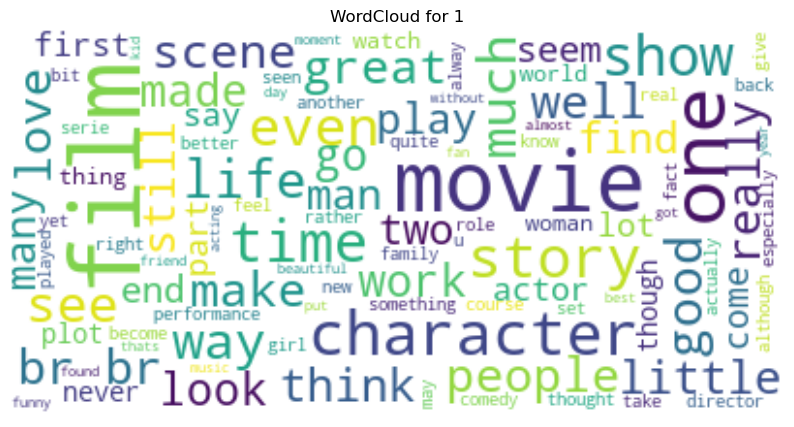

In [85]:
plot_word_cloud(data[data["Target"]==0], 0)
plot_word_cloud(data[data["Target"]==1], 1)

## 1. Sentiment Analysis using VADER
Run polarity score on entire dataset. Adding Polarity scores
We can see that we get a complete analysis of every review text as either positive or negative based on the compound values (aggregation of negative, neutral and positive).

In [88]:
sentiment = SentimentIntensityAnalyzer()

In [91]:
data["scores"] = data["Text"].apply(lambda Text: sentiment.polarity_scores(Text))
data.head()    

,Text,Target,scores
0,bromwell high cartoon comedy ran time program ...,1,"{'neg': 0.074, 'neu': 0.856, 'pos': 0.069, 'co..."
1,homelessness houselessness george carlin state...,1,"{'neg': 0.175, 'neu': 0.623, 'pos': 0.202, 'co..."
2,brilliant overacting lesley ann warren best dr...,1,"{'neg': 0.114, 'neu': 0.603, 'pos': 0.283, 'co..."
3,easily underrated film inn brook cannon sure f...,1,"{'neg': 0.099, 'neu': 0.611, 'pos': 0.291, 'co..."
4,typical mel brook film much le slapstick movie...,1,"{'neg': 0.063, 'neu': 0.644, 'pos': 0.293, 'co..."


### Testing on Random reviews
Calling out the compound part as a column on its own and running a random review to check for its scores. We see that the **random review** that I had run, comes out as negative.

In [94]:
data["compound"]= data["scores"].apply(lambda score_dict: score_dict["compound"])
data.head()

,Text,Target,scores,compound
0,bromwell high cartoon comedy ran time program ...,1,"{'neg': 0.074, 'neu': 0.856, 'pos': 0.069, 'co...",-0.1027
1,homelessness houselessness george carlin state...,1,"{'neg': 0.175, 'neu': 0.623, 'pos': 0.202, 'co...",0.7672
2,brilliant overacting lesley ann warren best dr...,1,"{'neg': 0.114, 'neu': 0.603, 'pos': 0.283, 'co...",0.9670
3,easily underrated film inn brook cannon sure f...,1,"{'neg': 0.099, 'neu': 0.611, 'pos': 0.291, 'co...",0.9403
4,typical mel brook film much le slapstick movie...,1,"{'neg': 0.063, 'neu': 0.644, 'pos': 0.293, 'co...",0.9403


In [95]:
review = "The movie was so boring, would not recommend to anyone"
sentiment.polarity_scores(review)

{'neg': 0.389, 'neu': 0.611, 'pos': 0.0, 'compound': -0.625}